In [ ]:
import pandas as pd
import numpy as np

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Global Constants
S_BOLD = "\033[1m"
E_BOLD = "\033[0m"

# Data Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
def data_preprocessing(short_dataset):
    """
    Load weather datasets, combine them, and prepare binary rain indicators
    with advanced meteorological features for improved prediction.

    Returns:
        DataFrame: Processed weather data with rainfall indicators and advanced features
    """

    # Data retrieved from "https://meteostat.net/" for Prague–Ruzyně meteorological station
    data1 = pd.read_csv('data_set/meteostat-01.01.2000-31.12.2003.csv')
    data2 = pd.read_csv('data_set/meteostat-01.01.2004-31.12.2009.csv')
    data3 = pd.read_csv('data_set/meteostat-01.01.2010-31.12.2015.csv')
    data4 = pd.read_csv('data_set/meteostat-01.01.2016-31.12.2024.csv')

    weather_data = pd.concat([data1, data2, data3, data4], ignore_index=True)
    weather_data.to_csv("data_set/meteostat-01.01.2000-31.12.2024", index=False)

    weather_data.rename(columns={
        'date': 'Date',
        'tavg': 'Avg. Temperature',
        'tmin': 'Min. Temperature',
        'tmax': 'Max. Temperature',
        'prcp': 'Total Precipitation',
        'snow': 'Snow Depth',
        'wdir': 'Wind Direction',
        'wspd': 'Wind Speed',
        'wpgt': 'Peak Gust',
        'pres': 'Air Pressure',
        'tsun': 'Sunshine Duration'
    }, inplace=True)

    def clean_weather_data(df: pd.DataFrame) -> pd.DataFrame:

        conv = pd.to_numeric(df["Total Precipitation"], errors="coerce")
        df.loc[conv.isna(), "Total Precipitation"] = 0
        return df

    weather_data = clean_weather_data(weather_data)

    weather_data['Date'] = pd.to_datetime(weather_data['Date'])

    # Přidání cyklických transformací pro sezónnost
    month = weather_data['Date'].dt.month
    weather_data['month_sin'] = np.sin(2 * np.pi * month / 12)
    weather_data['month_cos'] = np.cos(2 * np.pi * month / 12)

    day_of_year = weather_data['Date'].dt.dayofyear
    weather_data['day_sin'] = np.sin(2 * np.pi * day_of_year / 365)
    weather_data['day_cos'] = np.cos(2 * np.pi * day_of_year / 365)

    weather_data["Precipitation Binary"] = np.where(weather_data["Total Precipitation"].fillna(0) > 0, 1, 0)

    if short_dataset:
        # Return only last 20% of dataset
        total_rows = len(weather_data)
        start_index = int(total_rows * 0.80)
        weather_data = weather_data.iloc[start_index:].reset_index(drop=True)

    return weather_data

In [36]:
weather_data = data_preprocessing(short_dataset=False)
display(weather_data.tail(5))
display(weather_data.head(5))

,Date,Avg. Temperature,Min. Temperature,Max. Temperature,Total Precipitation,Snow Depth,Wind Direction,Wind Speed,Peak Gust,Air Pressure,Sunshine Duration,month_sin,month_cos,day_sin,day_cos,Precipitation Binary
9127,2024-12-27,-4.2,-6.6,-2.4,0.0,NaN,93.0,4.2,13.0,1038.1,NaN,-2.449294e-16,1.0,-5.161967e-02,0.998667,0
9128,2024-12-28,-3.9,-5.8,-2.2,0.0,NaN,77.0,3.8,13.0,1033.3,NaN,-2.449294e-16,1.0,-3.442161e-02,0.999407,0
9129,2024-12-29,-4.2,-6.4,-1.2,0.0,NaN,85.0,4.4,18.5,1030.7,NaN,-2.449294e-16,1.0,-1.721336e-02,0.999852,0
9130,2024-12-30,-1.7,-6.0,1.5,0.0,NaN,232.0,10.7,24.1,1031.3,NaN,-2.449294e-16,1.0,6.432491e-16,1.000000,0
9131,2024-12-31,-1.9,-5.7,3.0,0.0,NaN,203.0,6.0,22.2,1030.0,NaN,-2.449294e-16,1.0,1.721336e-02,0.999852,0


,Date,Avg. Temperature,Min. Temperature,Max. Temperature,Total Precipitation,Snow Depth,Wind Direction,Wind Speed,Peak Gust,Air Pressure,Sunshine Duration,month_sin,month_cos,day_sin,day_cos,Precipitation Binary
0,2000-01-01,-0.6,-1.7,0.4,0.0,30.0,226.0,11.1,NaN,1025.4,NaN,0.5,0.866025,0.017213,0.999852,0
1,2000-01-02,1.0,-0.7,3.1,0.0,41.0,263.0,13.8,NaN,1029.0,NaN,0.5,0.866025,0.034422,0.999407,0
2,2000-01-03,0.1,-1.1,1.1,0.0,30.0,242.0,22.8,NaN,1028.1,NaN,0.5,0.866025,0.051620,0.998667,0
3,2000-01-04,1.9,0.1,3.7,0.0,20.0,229.0,25.5,NaN,1021.9,NaN,0.5,0.866025,0.068802,0.997630,0
4,2000-01-05,2.7,-1.2,5.1,0.0,NaN,254.0,19.4,NaN,1021.9,NaN,0.5,0.866025,0.085965,0.996298,0


In [37]:
def backtest_always_rain(weather_data):
    """Backtesting strategy that predicts rain every day."""

    y_true = weather_data['Precipitation Binary'].shift(-1)[:-1].astype(int)
    y_pred = np.ones(len(y_true), dtype=int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print("=== Strategy: Every day predicted as precipitation day ===")
    print(f"{S_BOLD}Accuracy:  {accuracy:.4f}{E_BOLD}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}", end = "\n\n")
    
def backtest_never_rain(weather_data):
    """Backtesting strategy that predicts no rain every day."""
    
    y_true = weather_data['Precipitation Binary'].shift(-1)[:-1].astype(int)
    y_pred = np.zeros(len(y_true), dtype=int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print("=== Strategy: Every day predicted as No-precipitation day ===")
    print(f"{S_BOLD}Accuracy:  {accuracy:.4f}{E_BOLD}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}", end = "\n\n")

def weather_stats(weather_data):
    """Simple Weather Statistics about rain occurrence"""
    rain_days = weather_data['Precipitation Binary'].sum()
    total_days = len(weather_data)
    no_rain_days = total_days - rain_days
    
    rain_percentage = (rain_days / total_days) * 100
    no_rain_percentage = (no_rain_days / total_days) * 100
    
    print("=== Simple Weather Data Statistics ===")
    print(f"{S_BOLD}Total days: {total_days:,}{E_BOLD}")
    print(f"Precipitation days: {rain_days:,} ({S_BOLD}{rain_percentage:.2f}%){E_BOLD}")
    print(f"No-precipitation days: {no_rain_days:,} ({S_BOLD}{no_rain_percentage:.2f}%){E_BOLD}", end = "\n\n")    

In [38]:
weather_stats(weather_data)
backtest_always_rain(weather_data)
backtest_never_rain(weather_data)

=== Simple Weather Data Statistics ===
Total days: 9,132
Precipitation days: 3,536 (38.72%)
No-precipitation days: 5,596 (61.28%)

=== Strategy: Every day predicted as precipitation day ===
Accuracy:  0.3873
Precision: 0.3873
Recall:    1.0000
F1-Score:  0.5583

=== Strategy: Every day predicted as No-precipitation day ===
Accuracy:  0.6127
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000



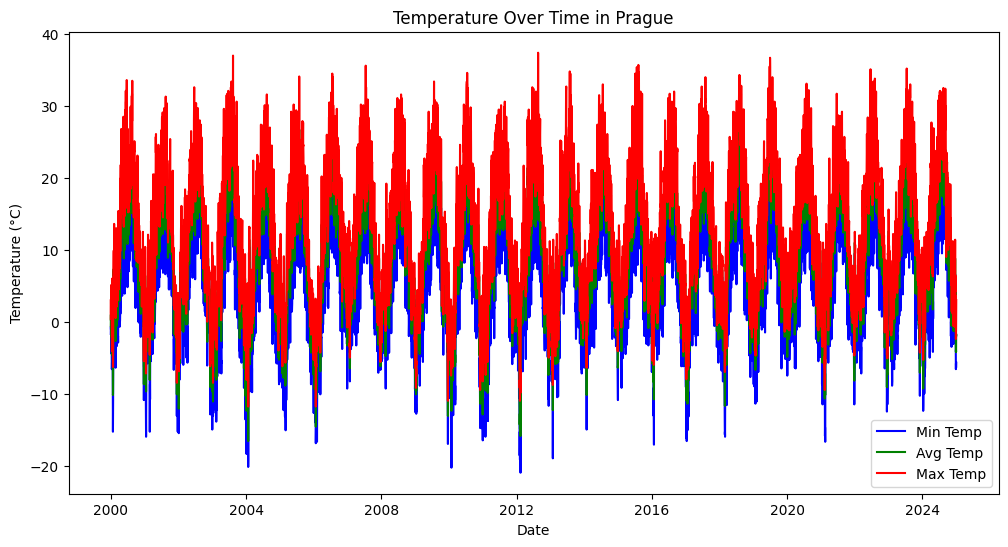

In [39]:
def plot_temperature_single(data, figsize=(12, 6)):
    """Plot all temperature variables on a single chart."""
    
    plt.figure(figsize=figsize)
    sns.lineplot(x='Date', y='Min. Temperature', data=data, color='blue', label='Min Temp')
    sns.lineplot(x='Date', y='Avg. Temperature', data=data, color='green', label='Avg Temp')
    sns.lineplot(x='Date', y='Max. Temperature', data=data, color='red', label='Max Temp')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature Over Time in Prague')
    plt.legend()
    plt.show()

plot_temperature_single(weather_data, figsize=(12, 6))

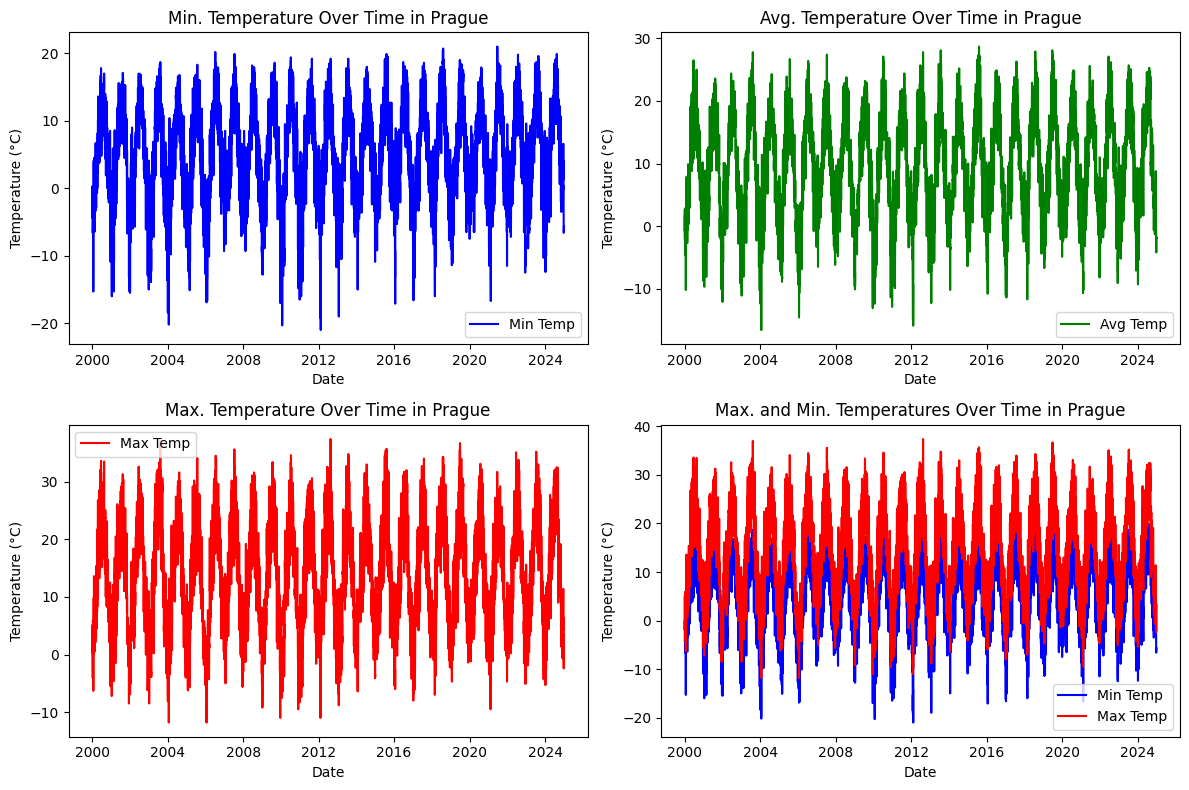

In [40]:
def plot_temperature_subplots(data, figsize=(12, 8)):
    """Plot temperature variables in separate subplots for detailed analysis."""
    
    plt.figure(figsize=figsize)

    # Min Temperature
    plt.subplot(2, 2, 1)
    sns.lineplot(x='Date', y='Min. Temperature', data=data, color='blue', label='Min Temp')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Min. Temperature Over Time in Prague')
    plt.legend()

    # Avg Temperature
    plt.subplot(2, 2, 2)
    sns.lineplot(x='Date', y='Avg. Temperature', data=data, color='green', label='Avg Temp')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Avg. Temperature Over Time in Prague')
    plt.legend()

    # Max Temperature
    plt.subplot(2, 2, 3)
    sns.lineplot(x='Date', y='Max. Temperature', data=data, color='red', label='Max Temp')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Max. Temperature Over Time in Prague')
    plt.legend()

    # Min and Max Together
    plt.subplot(2, 2, 4)
    sns.lineplot(x='Date', y='Min. Temperature', data=data, color='blue', label='Min Temp')
    sns.lineplot(x='Date', y='Max. Temperature', data=data, color='red', label='Max Temp')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Max. and Min. Temperatures Over Time in Prague')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_temperature_subplots(weather_data, figsize=(12, 8))    

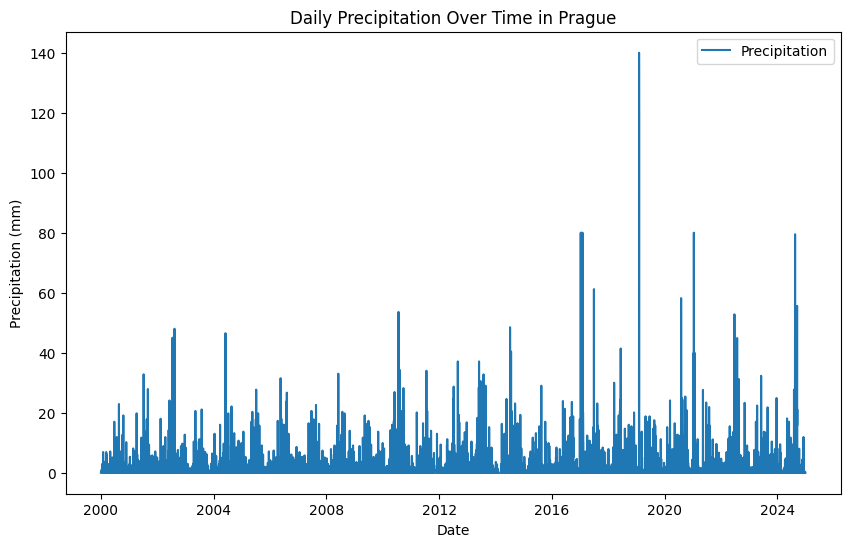

In [41]:
def plot_precipitation(data, figsize=(10, 6)):
    """Plot daily precipitation over time."""
    
    plt.figure(figsize=figsize)
    sns.lineplot(x='Date', y='Total Precipitation', data=data, label='Precipitation')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.title('Daily Precipitation Over Time in Prague')
    plt.legend()
    plt.show()

plot_precipitation(weather_data, figsize=(10, 6))

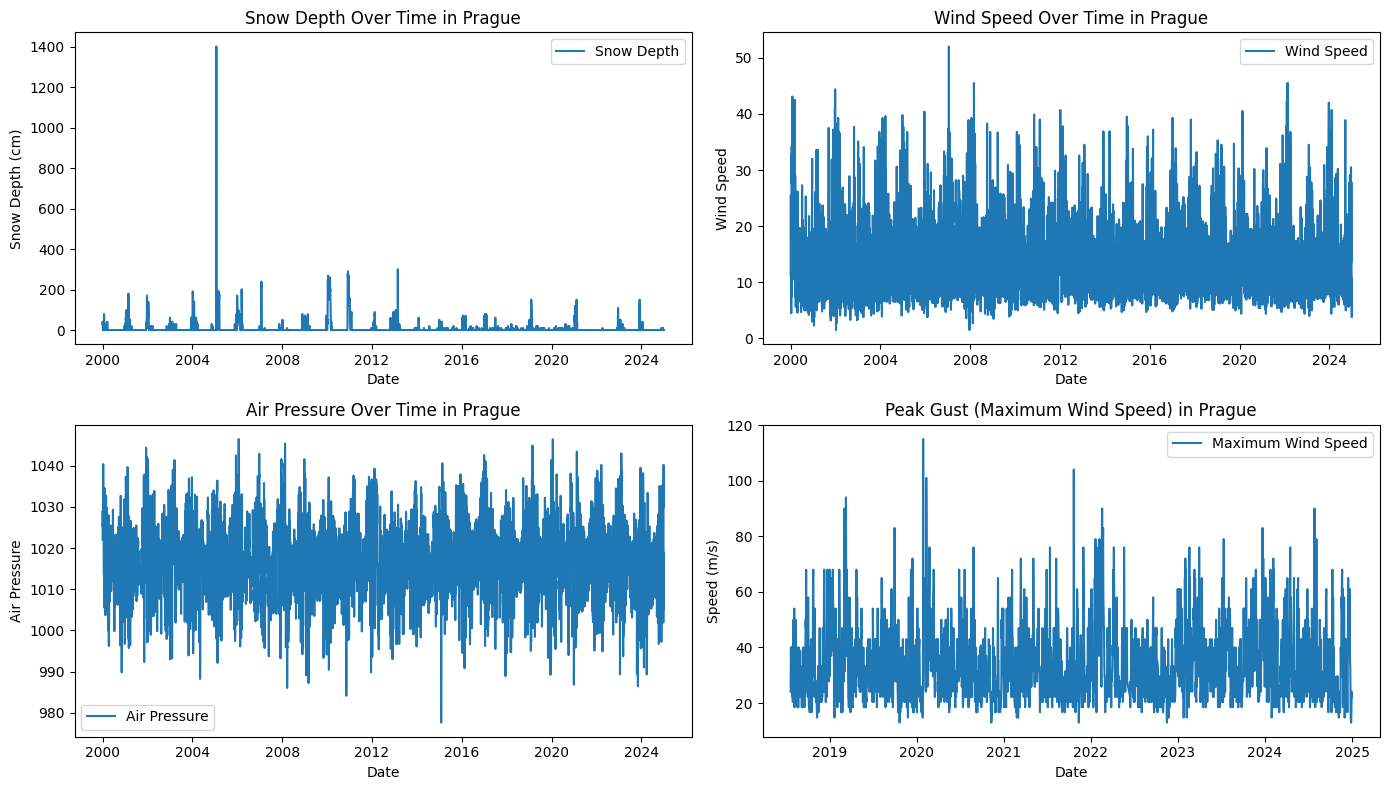

In [42]:
def plot_weather_variables(data, figsize=(14, 8)):
    """Plot multiple weather variables in subplots (snow, wind, pressure, gusts)."""
    
    data = data.copy()
    data['Snow Depth'] = data['Snow Depth'].fillna(0)
    
    plt.figure(figsize=figsize)

    # Snow Depth
    plt.subplot(2, 2, 1)
    sns.lineplot(x='Date', y='Snow Depth', data=data, label='Snow Depth')
    plt.xlabel('Date')
    plt.ylabel('Snow Depth (cm)')
    plt.title('Snow Depth Over Time in Prague')
    plt.legend()

    # Wind Speed
    plt.subplot(2, 2, 2)
    sns.lineplot(x='Date', y='Wind Speed', data=data, label='Wind Speed')
    plt.xlabel('Date')
    plt.ylabel('Wind Speed')
    plt.title('Wind Speed Over Time in Prague')
    plt.legend()

    # Air Pressure
    plt.subplot(2, 2, 3)
    sns.lineplot(x='Date', y='Air Pressure', data=data, label='Air Pressure')
    plt.xlabel('Date')
    plt.ylabel('Air Pressure')
    plt.title('Air Pressure Over Time in Prague')
    plt.legend()

    # Peak Gust
    plt.subplot(2, 2, 4)
    sns.lineplot(x='Date', y='Peak Gust', data=data, label='Maximum Wind Speed')
    plt.xlabel('Date')
    plt.ylabel('Speed (m/s)')
    plt.title('Peak Gust (Maximum Wind Speed) in Prague')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_weather_variables(weather_data, figsize=(14, 8))    

In [44]:
def weather_stats(weather_data):
    print("=== Basic Weather Data Information ===")
    print(f"Dataset dimensions: {weather_data.shape}")
    print(f"Time period: {weather_data['Date'].min()} to {weather_data['Date'].max()}")
    print(f"Total years: {(weather_data['Date'].max() - weather_data['Date'].min()).days / 365.25:.1f}")
    
    print("\n=== Precipitation Statistics ===")
    print(f"Precipitation days: {weather_data['Precipitation Binary'].sum():,} ({weather_data['Precipitation Binary'].mean()*100:.1f}%)")
    print(f"No precipitation days: {(~weather_data['Precipitation Binary'].astype(bool)).sum():,} ({(1-weather_data['Precipitation Binary'].mean())*100:.1f}%)")
    print(f"Average daily precipitation: {weather_data['Total Precipitation'].mean():.2f} mm")
    print(f"Maximum daily precipitation: {weather_data['Total Precipitation'].max():.2f} mm")
    
    print("\n=== Temperature Statistics ===")
    print(f"Average temperature: {weather_data['Avg. Temperature'].mean():.1f}°C")
    print(f"Coldest day: {weather_data['Min. Temperature'].min():.1f}°C")
    print(f"Hottest day: {weather_data['Max. Temperature'].max():.1f}°C")
    
    print("\n=== Seasonal Precipitation Distribution ===")
    seasonal_precipitation = weather_data.groupby(weather_data['Date'].dt.month)['Precipitation Binary'].agg(['mean', 'count'])
    seasonal_precipitation.columns = ['Precipitation_Frequency', 'Days_Count']
    seasonal_precipitation['Precipitation_Frequency'] = seasonal_precipitation['Precipitation_Frequency'] * 100
    print(seasonal_precipitation.round(1))
    
    print("\n=== Detailed Statistics of All Variables ===")
    print(weather_data.describe())

weather_stats(weather_data)    

=== Basic Weather Data Information ===
Dataset dimensions: (9132, 16)
Time period: 2000-01-01 00:00:00 to 2024-12-31 00:00:00
Total years: 25.0

=== Precipitation Statistics ===
Precipitation days: 3,536 (38.7%)
No precipitation days: 5,596 (61.3%)
Average daily precipitation: 1.57 mm
Maximum daily precipitation: 140.00 mm

=== Temperature Statistics ===
Average temperature: 9.4°C
Coldest day: -21.0°C
Hottest day: 37.4°C

=== Seasonal Precipitation Distribution ===
      Precipitation_Frequency  Days_Count
Date                                     
1                        45.7         775
2                        37.3         707
3                        37.2         775
4                        32.7         750
5                        41.4         775
6                        40.9         750
7                        44.6         775
8                        38.6         775
9                        34.1         750
10                       36.0         775
11                       3